# Proyek Klasifikasi Gambar: Shoe vs Sandal vs Boot Image Dataset
- **Nama:** Septi Isdayanna
- **Email:** septiisdaynnaa@gmail.com
- **ID Dicoding:** septi_isdayanna

## Import Semua Packages/Library yang Digunakan

In [3]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [ ]:
# Upload kaggle.json terlebih dahulu
from google.colab import files
files.upload()  # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"septiisdayanna","key":"-"}'}

In [ ]:
# Setup kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dan extract dataset
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
!unzip -q shoe-vs-sandal-vs-boot-dataset-15k-images.zip

Dataset URL: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
License(s): copyright-authors


### Data Preprocessing

#### Split Dataset

In [ ]:
# Path ke folder aslinya
original_dataset_dir = '/content/Shoe vs Sandal vs Boot Dataset'

# Folder target setelah split
base_dir = '/content/dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Kategori
categories = ['Shoe', 'Sandal', 'Boot']

# Buat struktur folder
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)
    for category in categories:
        os.makedirs(os.path.join(folder, category), exist_ok=True)

# Proses pembagian file per kategori
for category in categories:
    source_path = os.path.join(original_dataset_dir, category)
    all_files = os.listdir(source_path)

    # Filter hanya file gambar
    all_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Split 70/15/15
    train_files, temp_files = train_test_split(all_files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    # Salin ke folder train
    for file in train_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(train_dir, category, file))

    # Salin ke folder val
    for file in val_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(val_dir, category, file))

    # Salin ke folder test
    for file in test_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(test_dir, category, file))

print("Dataset berhasil dibagi menjadi Train, Val, dan Test")

Dataset berhasil dibagi menjadi Train, Val, dan Test


#### Load Data dengan ImageDataGenerator  

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/dataset_split/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    '/content/dataset_split/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    '/content/dataset_split/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 10500 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.


#### Plot gambar sampel untuk semua kelas

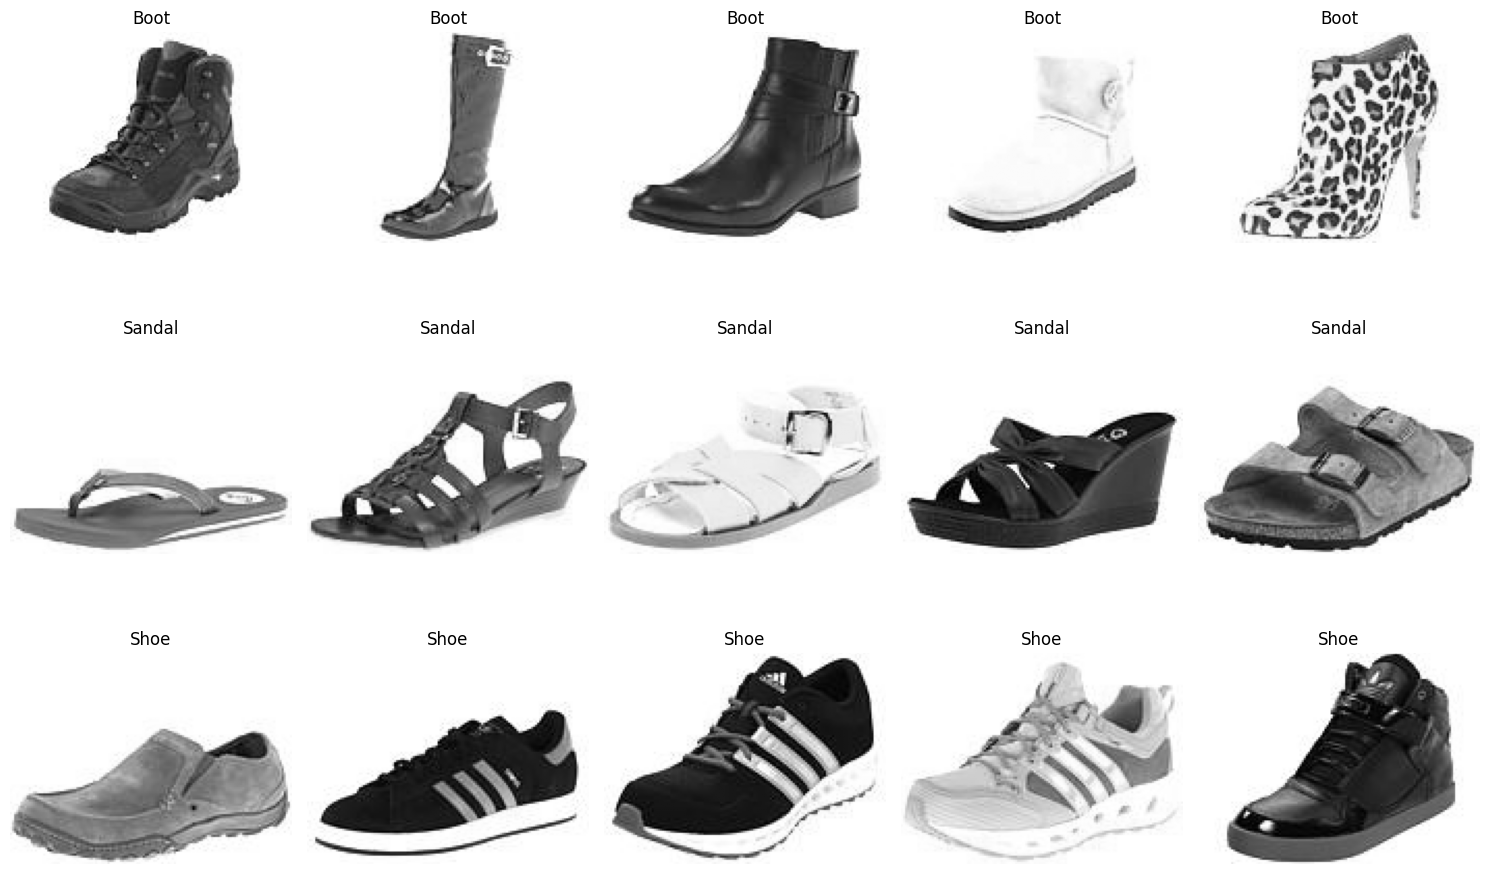

In [ ]:
# Path ke folder train
path = '/content/dataset_split/train'

# Inisialisasi dictionary untuk menyimpan list nama file per kelas
alas_kaki_images = {}

# Loop tiap folder kelas
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        alas_kaki_images[class_name] = os.listdir(class_path)

# Tampilkan 5 gambar acak dari tiap kelas
fig, axs = plt.subplots(len(alas_kaki_images.keys()), 5, figsize=(15, 10))

for i, class_name in enumerate(alas_kaki_images.keys()):
    images = np.random.choice(alas_kaki_images[class_name], 5, replace=False)
    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title(class_name)
        axs[i, j].axis('off')

fig.tight_layout()

#### Plot distribusi gambar di seluruh kelas

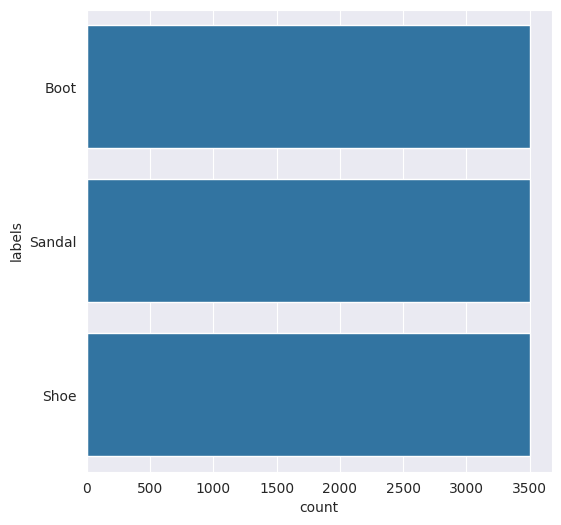

In [ ]:
# Path ke folder train
path = '/content/dataset_split/train'

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

## Modelling

#### Model Exp 1 - CNN Architecture (Using 32 Neurons in Conv Layer):

In [ ]:
model_1 = Sequential()

# Input layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer
model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Fully connected
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.3))

# Output layer (3 kelas, gunakan softmax)
model_1.add(Dense(3, activation='softmax'))

# Compile model
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Summary
model_1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,587 (5.35 MB)

 Trainable params: 1,403,395 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

## Callbacks

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5',  monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

callbacks = [early_stop, checkpoint, reduce_lr]

In [ ]:
# Ambil label dari train_generator
labels = train_generator.classes  # Ini adalah array label numerik

# Hitung class weight otomatis
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

# Ubah ke dictionary
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Fitting / training model
history_1 = model_1.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}
Epoch 1/30
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6872 - loss: 1.6249

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.6877 - loss: 1.6208 - val_accuracy: 0.8960 - val_loss: 0.3156 - learning_rate: 0.0010
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8964 - loss: 0.4016

329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.8964 - loss: 0.4014 - val_accuracy: 0.9311 - val_loss: 0.2824 - learning_rate: 0.0010
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9323 - loss: 0.2347

329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.9323 - loss: 0.2347 - val_accuracy: 0.9413 - val_loss: 0.2307 - learning_rate: 0.0010
Epoch 4/30
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9501 - loss: 0.1782

329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.9501 - loss: 0.1782 - val_accuracy: 0.9520 - val_loss: 0.1937 - learning_rate: 0.0010
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.9638 - loss: 0.1384 - val_accuracy: 0.9049 - val_loss: 0.4723 - learning_rate: 0.0010
Epoch 6/30
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9716 - loss: 0.1031

329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.9715 - loss: 0.1032 - val_accuracy: 0.9702 - val_loss: 0.1330 - learning_rate: 0.0010
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9712 - loss: 0.1153 - val_accuracy: 0.9387 - val_loss: 0.4231 - learning_rate: 0.0010
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9779 - loss: 0.0803 - val_accuracy: 0.9627 - val_loss: 0.1572 - learning_rate: 0.0010
Epoch 9/30
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9815 - loss: 0.0732

329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.9814 - loss: 0.0733 - val_accuracy: 0.9764 - val_loss: 0.1314 - learning_rate: 0.0010
Epoch 10/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.9821 - loss: 0.0709 - val_accuracy: 0.9476 - val_loss: 0.1631 - learning_rate: 0.0010
Epoch 11/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9829 - loss: 0.0639 - val_accuracy: 0.9658 - val_loss: 0.3238 - learning_rate: 0.0010
Epoch 12/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.9835 - loss: 0.0726 - val_accuracy: 0.9680 - val_loss: 0.1841 - learning_rate: 0.0010
Epoch 13/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9888 - loss: 0.0328 - val_accuracy: 0.9813 - val_loss: 0.1367 - learning_rate: 2.0000e-04
Epoch 14/30
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9926 - loss: 0.0224

329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9926 - loss: 0.0224 - val_accuracy: 0.9831 - val_loss: 0.1188 - learning_rate: 2.0000e-04
Epoch 15/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9956 - loss: 0.0156 - val_accuracy: 0.9840 - val_loss: 0.1230 - learning_rate: 2.0000e-04
Epoch 16/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9933 - loss: 0.0220 - val_accuracy: 0.9813 - val_loss: 0.1422 - learning_rate: 2.0000e-04
Epoch 17/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.9966 - loss: 0.0124 - val_accuracy: 0.9853 - val_loss: 0.1406 - learning_rate: 2.0000e-04
Epoch 18/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9963 - loss: 0.0141 - val_accuracy: 0.9858 - val_loss: 0.1191 - learning_rate: 4.0000e-05
Epoch 19/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9969 - loss: 0.0079 - val_accuracy: 0.9853 - val_loss: 0.1253 - learning_rate: 4.0000e-05


## Evaluasi dan Visualisasi

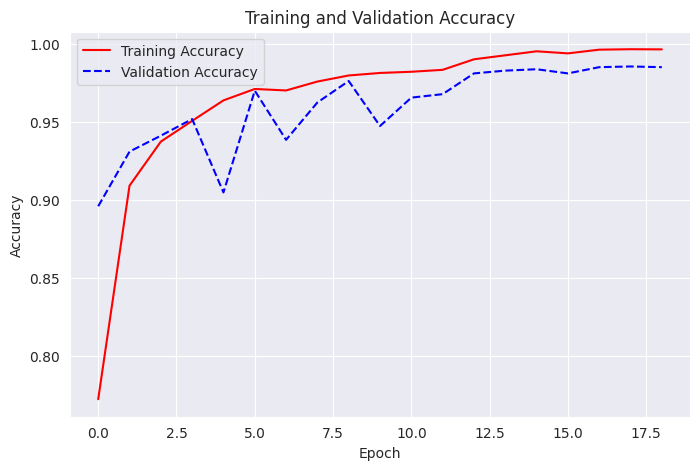

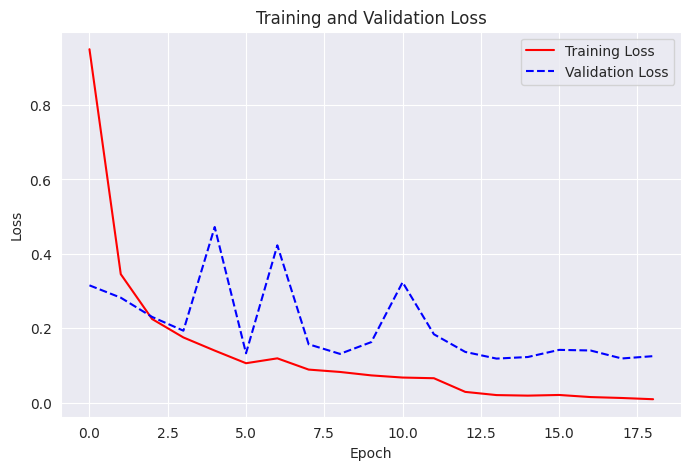

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

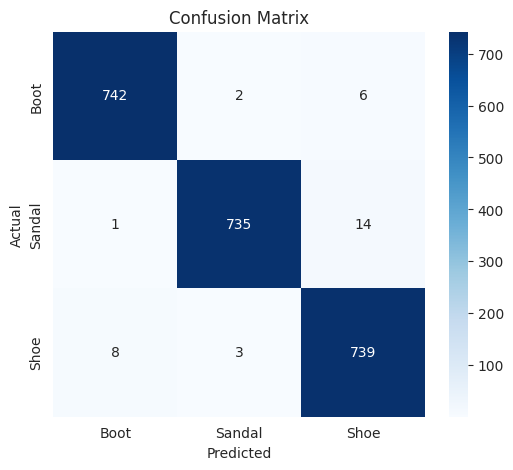


Classification Report:

              precision    recall  f1-score   support

        Boot     0.9880    0.9893    0.9887       750
      Sandal     0.9932    0.9800    0.9866       750
        Shoe     0.9736    0.9853    0.9795       750

    accuracy                         0.9849      2250
   macro avg     0.9850    0.9849    0.9849      2250
weighted avg     0.9850    0.9849    0.9849      2250



In [ ]:
# Reset generator
test_generator.reset()

# Prediksi
preds = model_1.predict(test_generator, verbose=0)
pred_labels = np.argmax(preds, axis=1)  # ambil label prediksi multiclass

# Ambil label asli
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())  # ['Boot', 'Sandal', 'Shoe']

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

## Konversi Model

In [ ]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
# Simpan model ke TFJS
!tensorflowjs_converter --input_format=keras best_model.h5 tfjs_model/

2025-04-20 19:45:35.068436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745178335.088960   17692 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745178335.094928   17692 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [9]:
# Simpan model TFLite
os.makedirs('tflite', exist_ok=True)
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Simpan file label.txt (ganti sesuai label kelasmu)
class_labels = ['Boot', 'Sandal', 'Shoe']  # urut sesuai label index
with open('tflite/label.txt', 'w') as f:
    for label in class_labels:
        f.write(label + '\n')

In [8]:
# Simpan model saved_model
model = tf.keras.models.load_model('best_model.h5')
model.export('/content/saved_model/')

Saved artifact at '/content/saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132339058073744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132339058074512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132339058073936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132339058075088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132339058069328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132339058074320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132339058075472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132339058076816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132339058076240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132339058077392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13233905

## Inference (Optional)

In [34]:
# Mencoba dengan model best_model.h5
from keras.models import load_model

# Load Model
model = load_model("best_model.h5")

# Fungsi untuk proses image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((150, 150))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path image
image_path = '/content/inference_image/testing.jpg'

# Memproses image
processed_image = preprocess_image(image_path)

# Melakukan prediksi
predictions = model.predict(processed_image)
predicted_class = np.argmax(predictions)
class_labels = ['Boot', 'Sandal', 'Shoes']

print("Predicted class:", class_labels[predicted_class])
print("Prediction probabilities:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
Predicted class: Sandal
Prediction probabilities: [[5.5535798e-31 1.0000000e+00 1.5482998e-21]]


In [36]:
# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

# Ambil detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load dan preprocess gambar
img = Image.open("/content/inference_image/testing2.jpeg").convert("RGB").resize((150, 150))
input_data = np.expand_dims(img, axis=0)         # Bentuk (1, 150, 150, 3)
input_data = np.array(input_data, dtype=np.float32) / 255.0

# Inference
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])

# Interpretasi output
predicted_class = np.argmax(output)  # Untuk model softmax multiclass

class_labels = ['Boot', 'Sandal', 'Shoe']

print("Predicted class:", class_labels[predicted_class])
print("Prediction probabilities:", output)

Predicted class: Shoe
Prediction probabilities: [[1.1848049e-06 2.5740063e-08 9.9999881e-01]]


In [37]:
from keras.layers import TFSMLayer

# Load model SavedModel sebagai inference-only layer
model = TFSMLayer('/content/saved_model/', call_endpoint='serving_default')
print("Model loaded.")

# Load dan preprocess gambar
img = Image.open('/content/inference_image/testing3.png').convert('RGB').resize((150, 150))
input_data = np.expand_dims(img, axis=0).astype(np.float32) / 255.0  # (1, 150, 150, 3)

# Prediksi
predictions = model(input_data)

# Ambil tensor dari dict output
output_tensor = list(predictions.values())[0]

# Proses hasil
predicted_class = np.argmax(output_tensor)
print(f"Predicted class: {class_labels[predicted_class]}")
print(f"Prediction probabilities: {output_tensor.numpy()[0]}")

Model loaded.
Predicted class: Boot
Prediction probabilities: [9.9999857e-01 1.9825192e-08 1.4127854e-06]


In [32]:
pip freeze > requirements.txt